# [2022 졸업논문팀] GAN 기법을 활용한 탄성파 이미지 해석 (Notebook #1)

## #1. 간단한 모델을 사용한 탄성파 데이터 분석

> <b>지도 :</b> 김도완 박사님  
> <b>연구 :</b> 이원석, 여주안, 서민종    

- obspy 라이브러리를 이용, 처리가 완료된 탄성파 탐사 데이터를 불러온다
- 탄성파 데이터를 가공하여 input 데이터셋을 만든다
- 간단한 모델을 적용하여 탄성파 데이터로 학습시킨다

Copyright © 2022 RISE Lab., Juan Yeo

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
from obspy.io.segy.segy import _read_segy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import hilbert

In [2]:
# 파일 용량: 4.5 MB, SEG-Y format
tr_glencoe = _read_segy('data/final_brglmt_mid_2160_3600.sgy')

# 규모값 계산 / 추출
num_traces_sgy = len(tr_glencoe.traces)
num_samples_sgy = tr_glencoe.traces[0].header.number_of_samples_in_this_trace

# (721, 2656) array 생성
traces_glencoe = np.zeros((num_samples_sgy, num_traces_sgy))

# 반복문으로 데이터 대입, trace 당 1 세로줄 column
for i in range(num_traces_sgy):
    traces_glencoe[:,i] = tr_glencoe.traces[i].data

In [4]:
print(traces_glencoe.shape)

(721, 2656)


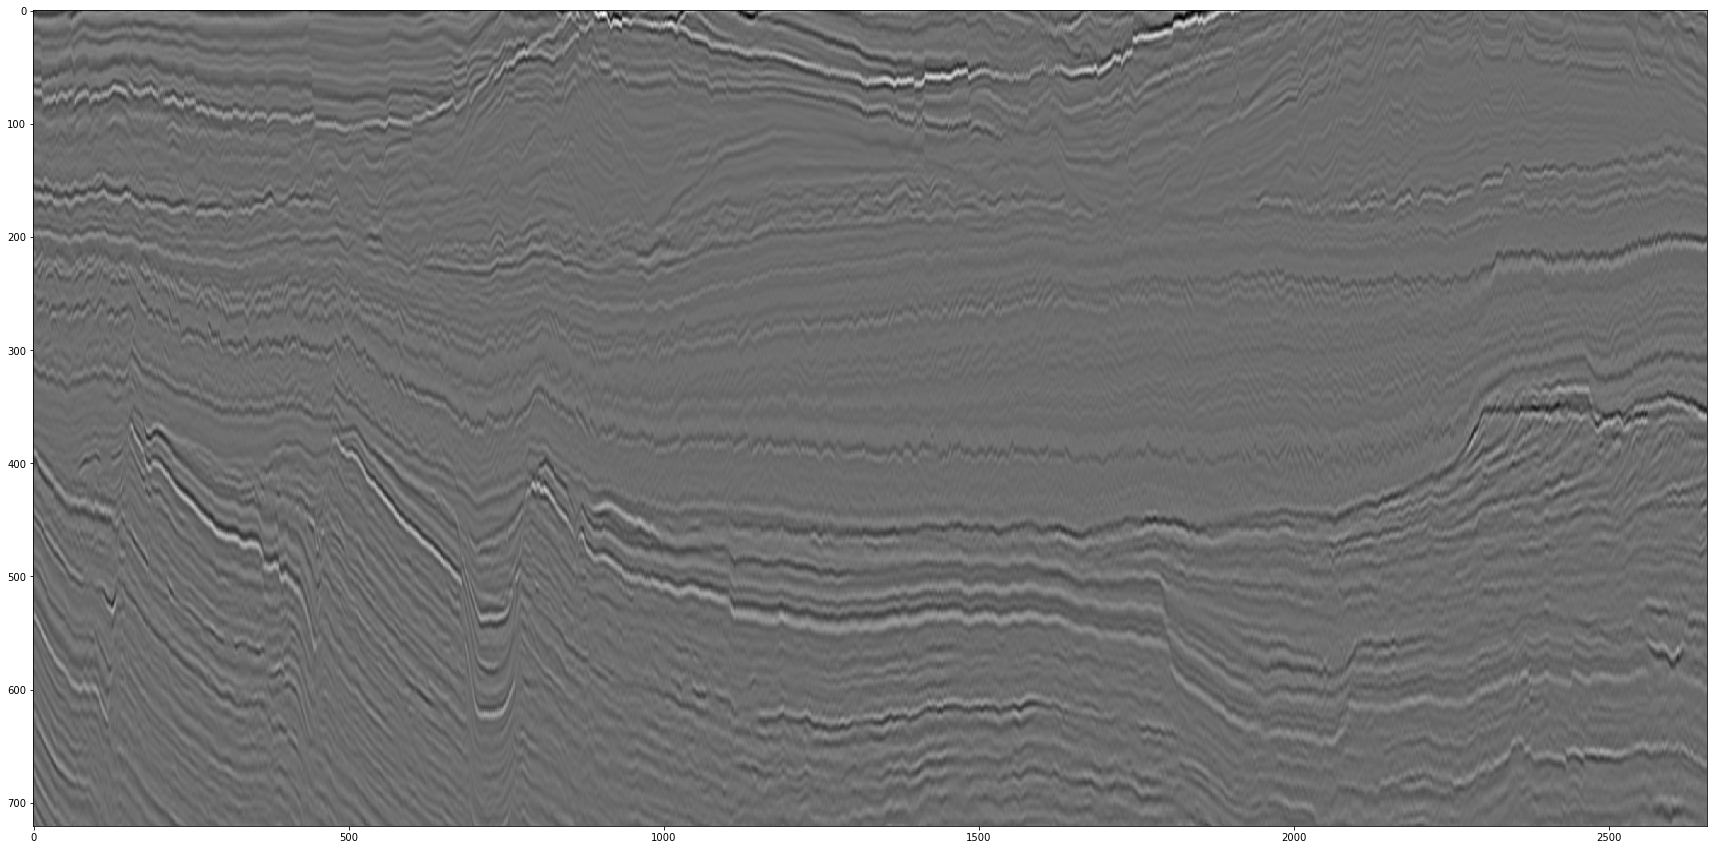

In [5]:
# Plotting
plt.figure(figsize=(30,15))
plt.imshow(traces_glencoe, cmap='gray_r', aspect='auto', interpolation = 'nearest')

In [24]:
traces_glencoe[0,:100]

array([ 239.,  233.,  230.,  229.,  180.,  195.,  159.,  156.,  103.,
         93.,   82.,   90.,   93.,  120.,  113.,  110.,   95.,   82.,
         87.,   82.,  104.,  112.,  126.,  121.,  129.,  118.,  109.,
        110.,  110.,  121.,  134.,  147.,  154.,  152.,  144.,  124.,
        119.,  113.,  138.,  148.,  188.,  194.,  200.,  240.,  236.,
        253.,  251.,  258.,  246.,  238.,  223.,  239.,  192.,  187.,
        100.,   97.,   47.,   87.,   94.,   -8.,  -21.,   20.,   58.,
        141.,  185.,  223.,  259.,  272.,  267.,  258.,  233.,  214.,
        183.,  167.,  172.,  150.,  111.,   13.,  -38., -115., -134.,
       -125., -104.,  -90., -114., -119., -129., -107., -107.,  -91.,
        -77.,  -73.,  -68.,  -63.,  -50.,  -40.,  -33.,  -28.,  -14.,
         -2.])

# 1. Linear Interpolation 적용 

> 선형 보간법을 사용해 20%의 데이터로 나머지 80%를 복원한다

In [3]:
traces_glencoe_dsamp_1 = traces_glencoe.copy()
data_index_1 = []

for i in range(traces_glencoe_dsamp_1.shape[1]):
    if i%5 != 4:
        traces_glencoe_dsamp_1[:,i] = np.nan
    else:
        data_index_1.append(i)
        
traces_glencoe_dsamp_1[:100]

array([[  nan,   nan,   nan, ...,   nan, -358.,   nan],
       [  nan,   nan,   nan, ...,   nan, -372.,   nan],
       [  nan,   nan,   nan, ...,   nan, -210.,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   10.,   nan],
       [  nan,   nan,   nan, ...,   nan,    3.,   nan],
       [  nan,   nan,   nan, ...,   nan,   -1.,   nan]])

In [4]:
traces_glencoe_dsamp_1 = np.ma.masked_invalid(traces_glencoe_dsamp_1)
traces_glencoe_dsamp_1 = traces_glencoe_dsamp_1[~traces_glencoe_dsamp_1.mask]

traces_glencoe_dsamp_1

masked_array(data=[180.0, 93.0, 113.0, ..., -21.0, 1.0, 4.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [69]:
np.asarray(data_index_1).shape

(531,)

In [5]:
traces_glencoe_interp_1 = np.zeros(traces_glencoe.shape)
index_arr = np.arange(traces_glencoe_interp_1.shape[1])
data_index_length = 531

for i in range(traces_glencoe_interp_1.shape[0]):
    traces_glencoe_interp_1[i] = np.interp(index_arr, np.asarray(data_index_1), traces_glencoe_dsamp_1.data[i*data_index_length:(i+1)*data_index_length])
    
traces_glencoe_interp_1[0,:40]

array([180. , 180. , 180. , 180. , 180. , 162.6, 145.2, 127.8, 110.4,
        93. ,  97. , 101. , 105. , 109. , 113. , 106.8, 100.6,  94.4,
        88.2,  82. ,  91.4, 100.8, 110.2, 119.6, 129. , 127.4, 125.8,
       124.2, 122.6, 121. , 125.6, 130.2, 134.8, 139.4, 144. , 144.8,
       145.6, 146.4, 147.2, 148. ])

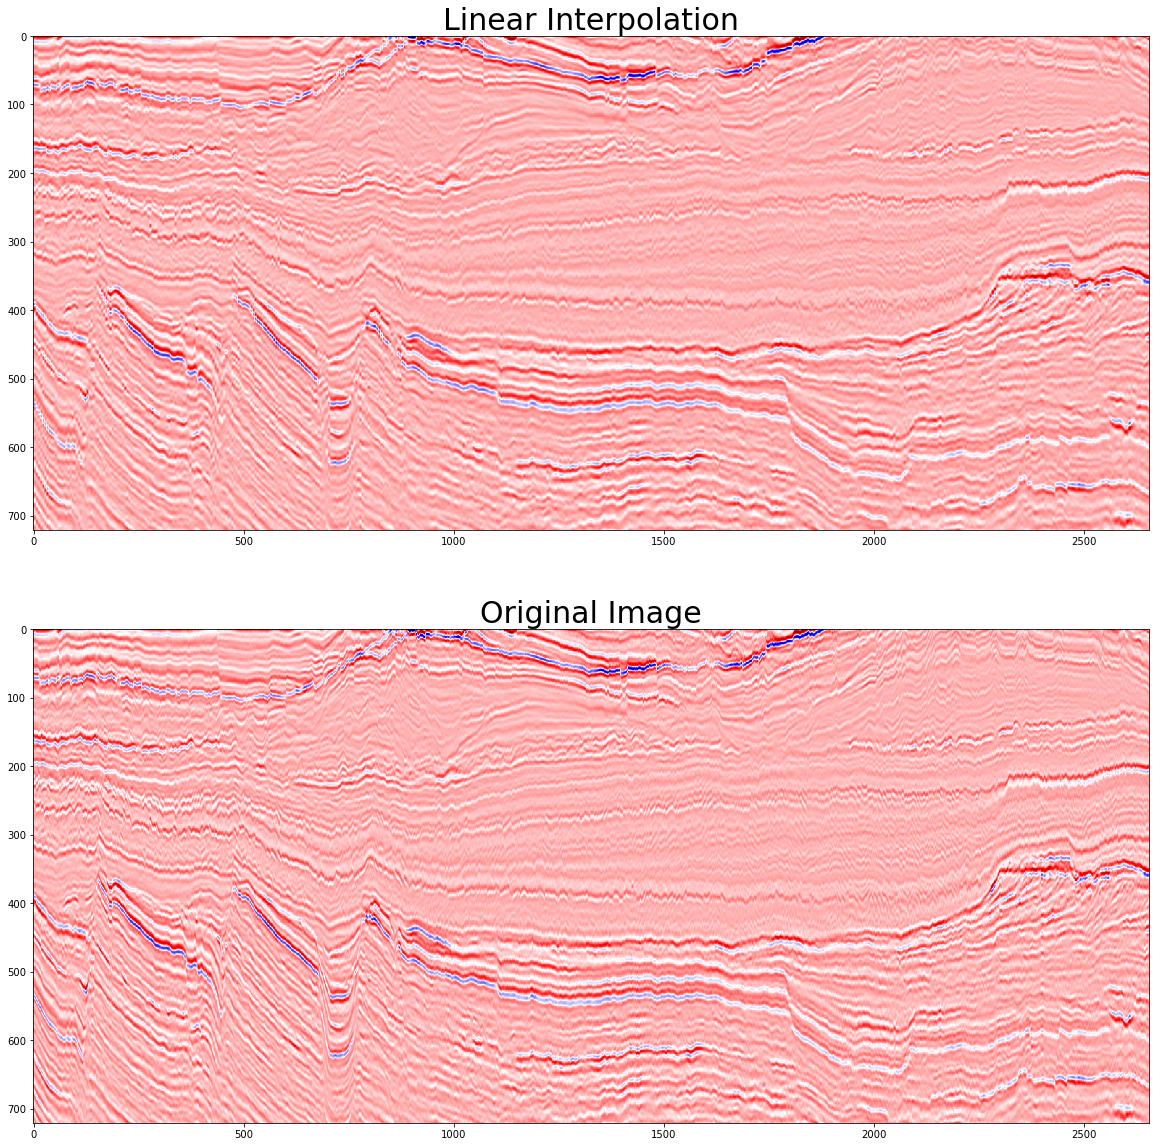

In [84]:
# Plotting Linear Interpolation Result
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2, 1, 1)
ax1.imshow(traces_glencoe_interp_1, cmap='seismic', aspect='auto', interpolation = 'nearest')
ax1.set_title('Linear Interpolation', fontsize = 30)
 
ax2 = fig.add_subplot(2, 1, 2)
ax2.imshow(traces_glencoe, cmap='seismic', aspect='auto', interpolation = 'nearest')
ax2.set_title('Original Image', fontsize = 30)
 
plt.show()

# 2. Cubic Interpolation 적용  

> 삼차 보간법을 사용해 20%의 데이터로 나머지 80%를 복원한다

In [6]:
traces_glencoe_dsamp_2 = traces_glencoe.copy()
data_index_2 = []

for i in range(traces_glencoe_dsamp_2.shape[1]):
    if i%5 != 4:
        traces_glencoe_dsamp_2[:,i] = np.nan
    else:
        data_index_2.append(i)
        
traces_glencoe_dsamp_2 = np.ma.masked_invalid(traces_glencoe_dsamp_2)
traces_glencoe_dsamp_2 = traces_glencoe_dsamp_2[~traces_glencoe_dsamp_2.mask]

traces_glencoe_interp_2 = np.zeros(traces_glencoe.shape)
index_arr = np.arange(traces_glencoe_interp_2.shape[1])
data_index_length = np.asarray(data_index_1).shape[0]

for i in range(traces_glencoe_interp_1.shape[0]):
    spline_representation = interpolate.splrep(np.asarray(data_index_2), traces_glencoe_dsamp_2.data[i*data_index_length:(i+1)*data_index_length])
    traces_glencoe_interp_2[i] = interpolate.splev(index_arr, spline_representation)
    
traces_glencoe_interp_2[0,:40]

array([500.65204472, 391.28174197, 302.76401491, 233.02729157,
       180.        , 141.61056823, 115.78742431, 100.45899627,
        93.55371216,  93.        ,  96.72628784, 102.66100373,
       108.73257569, 112.86943177, 113.        , 107.86028039,
        99.41656078,  90.44270098,  83.71256078,  82.        ,
        87.14459059,  97.24875315, 109.4806204 , 121.00832511,
       129.        , 131.45735724, 129.71642663, 125.9468174 ,
       122.31813879, 121.        , 123.51398046, 128.78954034,
       135.10810998, 140.75111975, 144.        , 143.80672092,
       141.80541203, 140.30074267, 141.59738221, 148.        ])

In [109]:
traces_glencoe_interp_1[0,:40]

array([180. , 180. , 180. , 180. , 180. , 162.6, 145.2, 127.8, 110.4,
        93. ,  97. , 101. , 105. , 109. , 113. , 106.8, 100.6,  94.4,
        88.2,  82. ,  91.4, 100.8, 110.2, 119.6, 129. , 127.4, 125.8,
       124.2, 122.6, 121. , 125.6, 130.2, 134.8, 139.4, 144. , 144.8,
       145.6, 146.4, 147.2, 148. ])

In [110]:
traces_glencoe_interp_2[0,:40]

array([500.65204472, 391.28174197, 302.76401491, 233.02729157,
       180.        , 141.61056823, 115.78742431, 100.45899627,
        93.55371216,  93.        ,  96.72628784, 102.66100373,
       108.73257569, 112.86943177, 113.        , 107.86028039,
        99.41656078,  90.44270098,  83.71256078,  82.        ,
        87.14459059,  97.24875315, 109.4806204 , 121.00832511,
       129.        , 131.45735724, 129.71642663, 125.9468174 ,
       122.31813879, 121.        , 123.51398046, 128.78954034,
       135.10810998, 140.75111975, 144.        , 143.80672092,
       141.80541203, 140.30074267, 141.59738221, 148.        ])

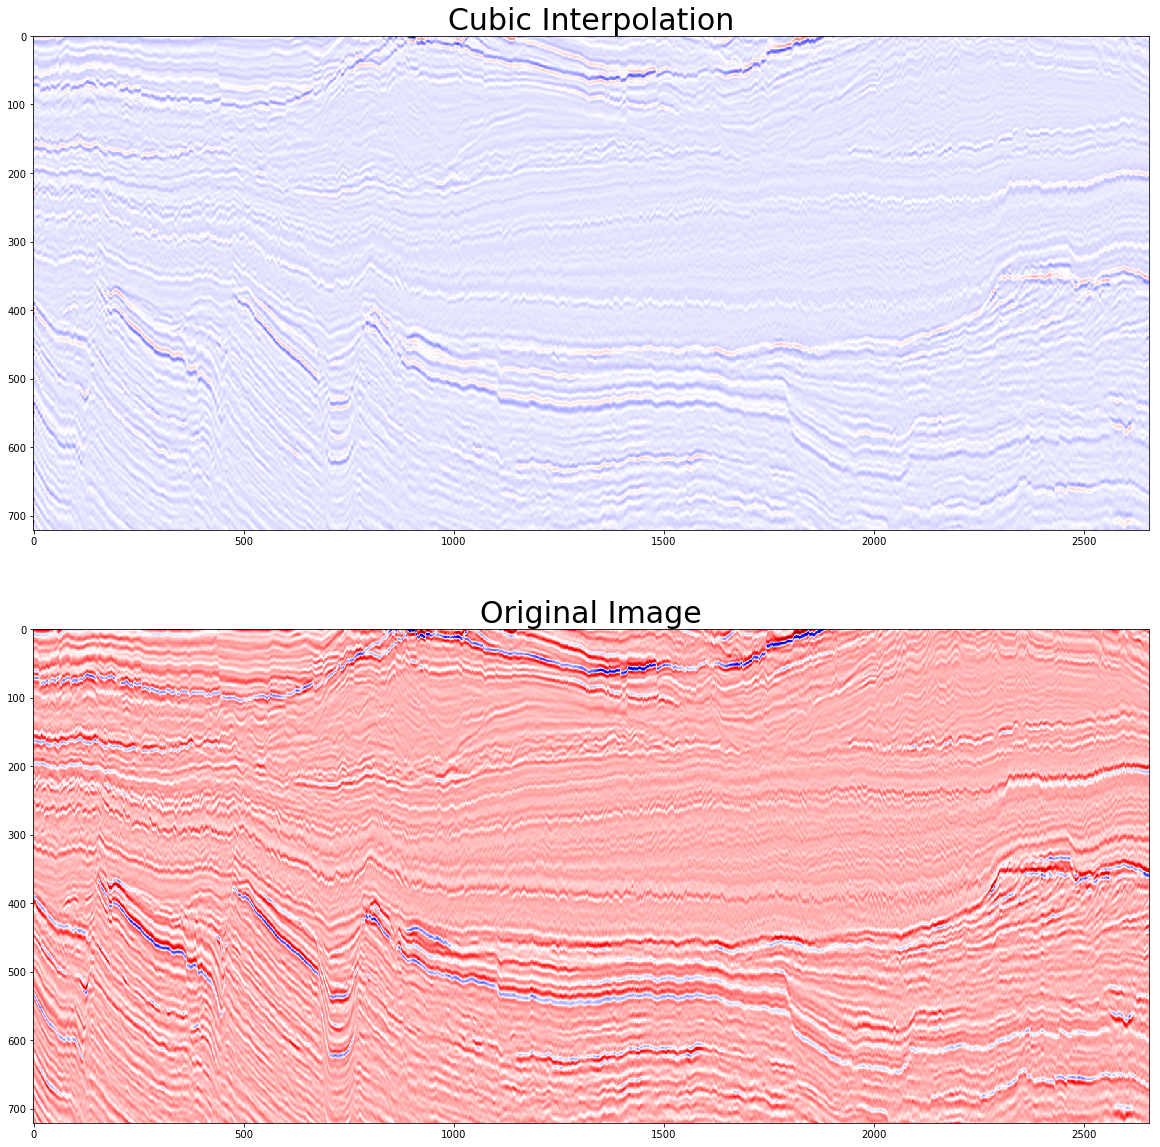

In [7]:
# Plotting Cubic Interpolation Result
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2, 1, 1)
ax1.imshow(traces_glencoe_interp_2, cmap='seismic', aspect='auto', interpolation = 'nearest')
ax1.set_title('Cubic Interpolation', fontsize = 30)
 
ax2 = fig.add_subplot(2, 1, 2)
ax2.imshow(traces_glencoe, cmap='seismic', aspect='auto', interpolation = 'nearest')
ax2.set_title('Original Image', fontsize = 30)
 
plt.show()

In [141]:
traces_glencoe_interp_2.sum()

71036.99423497015

In [142]:
traces_glencoe.sum()

74852.0

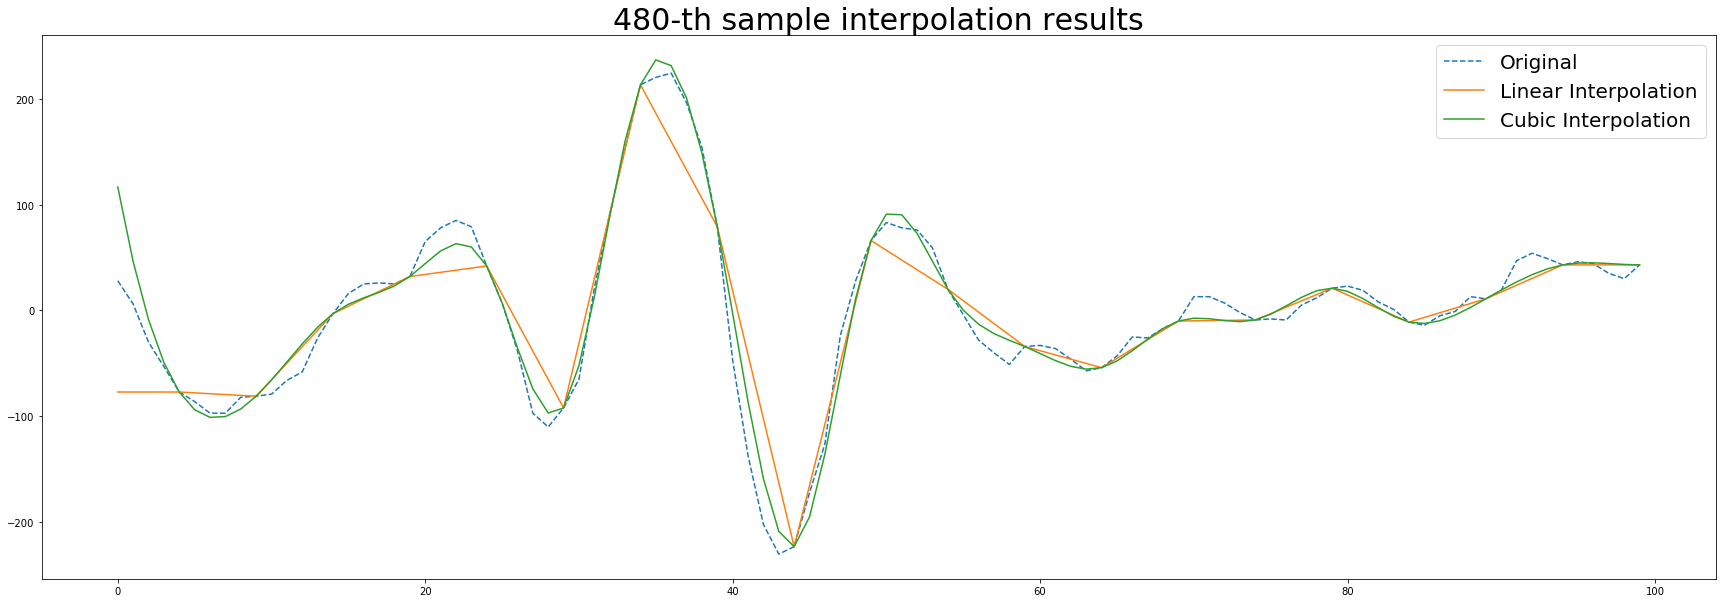

In [137]:
n = 480 # 설정값 n < 721

plt.figure(figsize=(30,10))
labels = ['']
x = np.arange(100)
plt.plot(x, traces_glencoe[n,:100], '--', label='Original')
plt.plot(x, traces_glencoe_interp_1[n,:100], label='Linear Interpolation')
plt.plot(x, traces_glencoe_interp_2[n,:100], label='Cubic Interpolation')
plt.legend(fontsize=20)
plt.title('{}-th sample interpolation results'.format(n), fontsize=30)
plt.show()

## 적용 3. Neural Network  

> 인공신경망을 사용해 20%의 데이터로 나머지 80%를 복원한다

## Input 생성

- input, output 구조는 아래와 같다

![nn](input_structure.png)

In [3]:
data_rows = []

for sample_i in range(0, traces_glencoe.shape[0] - 4):
    for trace_i in range(0, traces_glencoe.shape[1] - 5):
        row = [traces_glencoe[sample_i, trace_i], traces_glencoe[sample_i+1, trace_i], 
                   traces_glencoe[sample_i+2, trace_i], traces_glencoe[sample_i+3, trace_i],
                   traces_glencoe[sample_i+4, trace_i], traces_glencoe[sample_i, trace_i+5],
                   traces_glencoe[sample_i+1, trace_i+5], traces_glencoe[sample_i+2, trace_i+5],
                   traces_glencoe[sample_i+3, trace_i+5], traces_glencoe[sample_i+4, trace_i+5],
                   traces_glencoe[sample_i+2, trace_i+1], traces_glencoe[sample_i+2, trace_i+2],
                   traces_glencoe[sample_i+2, trace_i+3], traces_glencoe[sample_i+2, trace_i+4]]
        data_rows.append(row)

print(len(data_rows))

1900767


In [4]:
data_array = np.asarray(data_rows)
df = pd.DataFrame({'lt2': data_array[:,0], 'lt1': data_array[:,1], 'lm': data_array[:,2], 
                            'lb1': data_array[:,3], 'lb2': data_array[:,4], 'rt2': data_array[:,5], 
                            'rt1': data_array[:,6], 'rm': data_array[:,7], 'rb1': data_array[:,8], 
                            'rb2': data_array[:,9], 'label_left_2': data_array[:,10], 
                            'label_left_1': data_array[:,11], 'label_right_1': data_array[:,12], 
                            'label_right_2': data_array[:,13]})

df.head()

label_left_1  label_left_2  label_right_1  label_right_2    lb1    lb2  \
0         291.0         291.0          286.0          270.0  227.0  150.0   
1         286.0         291.0          270.0          274.0  233.0  151.0   
2         270.0         286.0          274.0          270.0  237.0  157.0   
3         274.0         270.0          270.0          263.0  229.0  148.0   
4         270.0         274.0          263.0          243.0  246.0  189.0   

      lm    lt1    lt2    rb1    rb2     rm    rt1    rt2  
0  284.0  302.0  239.0  240.0  176.0  274.0  265.0  195.0  
1  291.0  302.0  233.0  261.0  212.0  270.0  236.0  159.0  
2  291.0  300.0  230.0  253.0  206.0  263.0  231.0  156.0  
3  286.0  297.0  229.0  268.0  244.0  243.0  181.0  103.0  
4  270.0  252.0  180.0  272.0  252.0  241.0  173.0   93.0

## Test Set, Train Set 분할

In [5]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,4:]
Y = df.iloc[:,:4]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [8]:
X.sample(1)

lb1    lb2    lm   lt1   lt2    rb1    rb2     rm   rt1   rt2
657712 -69.0 -104.0 -25.0  13.0  30.0 -135.0 -141.0 -116.0 -86.0 -49.0

In [9]:
Y.sample(1)

label_left_1  label_left_2  label_right_1  label_right_2
1689062          -5.0           6.0          -19.0          -14.0

In [10]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:10]
Y = df.iloc[:,10:]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [11]:
X.sample(1)

label_left_1  label_left_2  label_right_1  label_right_2   lb1   lb2  \
1602849          25.0          33.0           19.0           20.0  49.0  45.0   

           lm   lt1  lt2   rb1  
1602849  42.0  25.0  2.0  37.0

In [12]:
Y.sample(1)

rb2    rm   rt1   rt2
527763 -24.0  51.0  85.0  94.0

## 모델 구현

In [40]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

# Dense Layers
model.add(Dense(32, input_dim=10, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer
model.add(Dense(4))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_32 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 132       
Total params: 1,540
Trainable params: 1,540
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [42]:
model.fit(X_train, Y_train, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
1520613/1520613 [==============================] - 21s 14us/step - loss: 341.2703 - mean_absolute_error: 11.7424
Epoch 2/10
1520613/1520613 [==============================] - 20s 13us/step - loss: 319.5559 - mean_absolute_error: 11.4374
Epoch 3/10
1520613/1520613 [==============================] - 20s 13us/step - loss: 316.8916 - mean_absolute_error: 11.3977
Epoch 4/10
1520613/1520613 [==============================] - 20s 13us/step - loss: 315.2490 - mean_absolute_error: 11.3745
Epoch 5/10
1520613/1520613 [==============================] - 20s 13us/step - loss: 314.3911 - mean_absolute_error: 11.3614
Epoch 6/10
1520613/1520613 [==============================] - 20s 13us/step - loss: 313.7571 - mean_absolute_error: 11.3530
Epoch 7/10
1520613/1520613 [==============================] - 20s 13us/step - loss: 312.6460 - mean_absolute_error: 11.3397
Epoch 8/10
1520613/1520613 [==============================] - 20s 13us/step - loss: 311.9921 - mean_absolute_error: 11.3337
Epoch 9/

## 모델 성능 평가

In [43]:
model.evaluate(X_test, Y_test)

380154/380154 [==============================] - 5s 14us/step


[309.40549344926217, 11.267785434387944]

In [44]:
model.predict(X_test.iloc[:10])

array([[  63.87363  ,   73.30803  ,   52.374992 ,   41.4977   ],
       [  28.655756 ,   18.109463 ,   39.431038 ,   49.056667 ],
       [ -38.06694  ,  -37.065884 ,  -39.68698  ,  -41.601112 ],
       [ -41.65807  ,  -47.674763 ,  -35.66743  ,  -30.753319 ],
       [  31.698141 ,   43.034546 ,   18.037464 ,    6.1079206],
       [  11.129072 ,   11.427053 ,   10.836684 ,   10.907756 ],
       [  24.808521 ,   26.356728 ,   22.79832  ,   21.08267  ],
       [  10.111211 ,    6.8619285,   13.459753 ,   16.539799 ],
       [  41.639217 ,   42.268677 ,   40.217377 ,   38.898056 ],
       [ -23.90339  ,   55.383167 , -118.73835  , -208.6822   ]],
      dtype=float32)

In [45]:
Y_test.iloc[:10]

label_left_1  label_left_2  label_right_1  label_right_2
1589640          67.0          75.0           54.0           54.0
1210431          35.0          17.0           56.0           63.0
685828          -23.0         -33.0          -25.0          -33.0
1340809         -23.0         -25.0          -25.0          -26.0
1652450          48.0          55.0           17.0            3.0
518755            2.0           4.0            4.0            8.0
463514           47.0          42.0           45.0           33.0
951983            5.0           4.0            5.0            7.0
1576918          25.0          39.0           30.0           38.0
1007556          28.0          72.0          -77.0         -187.0

In [49]:
X_test.shape

(380154, 10)

In [50]:
model.predict(np.asarray([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]]))

array([[9.541302 , 9.594376 , 9.3643055, 9.307963 ]], dtype=float32)

In [57]:
model.predict(np.asarray([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]]))[0][0]

9.541302

In [61]:
traces_glencoe[2,:11]

array([284., 291., 291., 286., 270., 274., 270., 263., 243., 241., 243.])

## 학습된 모델로 데이터 복원

In [62]:
traces_glencoe_interp_3 = traces_glencoe.copy()

for sample_i in range(0, traces_glencoe.shape[0] - 4):
    for trace_i in range(0, traces_glencoe.shape[1] - 5, 5):
        predict = model.predict(np.asarray([[traces_glencoe[sample_i, trace_i], traces_glencoe[sample_i+1, trace_i], 
                   traces_glencoe[sample_i+2, trace_i], traces_glencoe[sample_i+3, trace_i],
                   traces_glencoe[sample_i+4, trace_i], traces_glencoe[sample_i, trace_i+5],
                   traces_glencoe[sample_i+1, trace_i+5], traces_glencoe[sample_i+2, trace_i+5],
                   traces_glencoe[sample_i+3, trace_i+5], traces_glencoe[sample_i+4, trace_i+5]]]))
        traces_glencoe_interp_3[sample_i+2, trace_i+1:trace_i+5] = predict[0]

traces_glencoe_interp_3[2,:11]

array([284.        , 250.61274719, 252.22554016, 245.37734985,
       236.91038513, 274.        , 226.77410889, 233.0871582 ,
       215.27236938, 200.30856323, 243.        ])

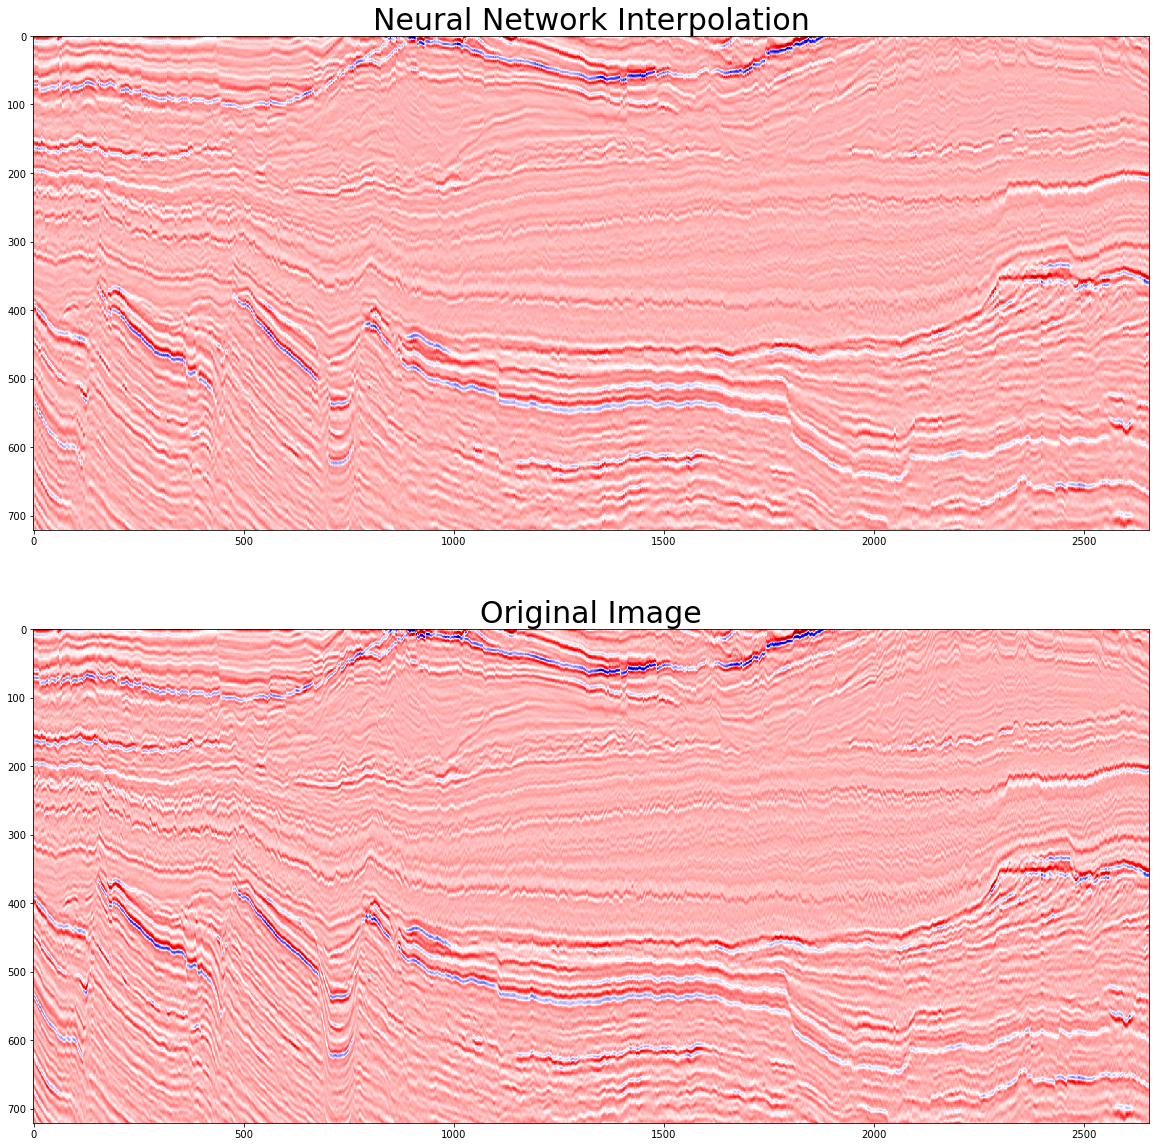

In [63]:
# Plotting Cubic Interpolation Result
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(2, 1, 1)
ax1.imshow(traces_glencoe_interp_3, cmap='seismic', aspect='auto', interpolation = 'nearest')
ax1.set_title('Neural Network Interpolation', fontsize = 30)
 
ax2 = fig.add_subplot(2, 1, 2)
ax2.imshow(traces_glencoe, cmap='seismic', aspect='auto', interpolation = 'nearest')
ax2.set_title('Original Image', fontsize = 30)
 
plt.show()

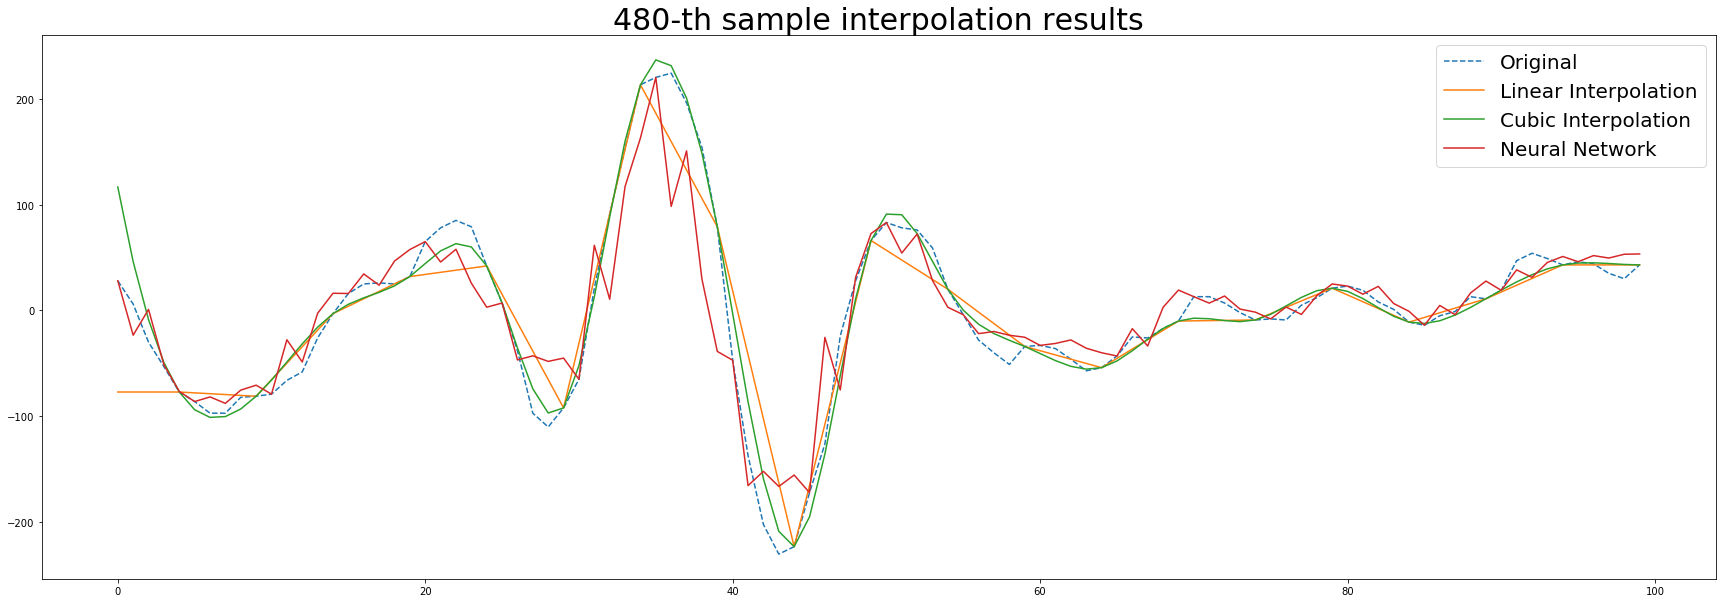

In [69]:
n = 480 # 설정값 n < 721

plt.figure(figsize=(30,10))
labels = ['']
x = np.arange(100)
plt.plot(x, traces_glencoe[n,:100], '--', label='Original')
plt.plot(x, traces_glencoe_interp_1[n,:100], label='Linear Interpolation')
plt.plot(x, traces_glencoe_interp_2[n,:100], label='Cubic Interpolation')
plt.plot(x, traces_glencoe_interp_3[n,:100], label='Neural Network')
plt.legend(fontsize=20)
plt.title('{}-th sample interpolation results'.format(n), fontsize=30)
plt.show()